# 대여소수/거치대수와 자전거 사고간의 관계 찾기

### 사용데이터
- 자전거 사고다발지역 정보 (2012~2018) [TAAS 도로교통공단]
- 서울시 공공자전거 대여소 정보 (2019.12.10 갱신 데이터) [서울 열린 데이터 광장]

'서울시 공공자전거 대여소 정보' 데이터를 이용하여 __대여소수/거치대수에 대한 단순통계 및 시각화__를 수행한다.<br>
'자전거 사고다발지역정보'와 '서울시 공공자전거 대여소 정보' 데이터를 이용하여 __대여소수/거치대수와 자전거 사고 간의 관계__를 비교 한다.

In [1]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins

import warnings
warnings.filterwarnings('ignore')

geo_path = 'data/seoul_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'Malgun Gothic'

## 자전거사고다발지역정보 가져오기
---------------------------------------------------------------------------------------------------------------------------------------

In [2]:
# 자전거사고다발지역정보 읽어오기
# 시도시군구명 컬럼에서 '서울특별시'가 포함된 행만 추출하여 accident_seoul 이라는 변수에 넣는다.
# 위도와 경도 컬럼에 결측치가 있을 경우 해당 행은 제거하도록 한다.

accident = pd.read_csv('data/자전거사고다발지역정보.csv', encoding = 'CP949')
accident_seoul = accident.loc[accident['시도시군구명'].str.contains('서울특별시')]
accident_seoul=accident_seoul.dropna(subset=['위도'])
accident_seoul=accident_seoul.dropna(subset=['경도'])

In [3]:
# 지점명 컬럼에 있는 내용들을 공백 마다 자르고, 두번째 단어만을 이용하여 '지역구' 컬럼에 새로이 추가한다. 
#지역구에 있는 구별로 묶을 수 있게 된다.

accident_seoul['지역구']=accident['지점명'].str.split(" ").str[1]
accident_seoul=accident_seoul.drop(['다발지역폴리곤'], axis='columns')
accident_seoul.head()

# size() 함수를 이용하여 지역구 별로 사고다발지가 몇군데 있는지 확인 할 수 있다.
# size() 함수를 이용한 뒤, type을 확인해보면 Series로 확인 된다. 사용에 편리를 주기 위해 Data Frame으로 변경하였다.

accident_seoul_gu = accident_seoul.groupby('지역구').size()
accident_seoul_gu = accident_seoul_gu.to_frame()
accident_seoul_gu.columns = ['사고다발지 개수']

# agg() 함수를 이용하여 지역구 별로 사고다발지에서 몇 건의 사고가 발생했는지 알 수 있다.
accident_seoul_gu_total = accident_seoul.groupby(['지역구'])[['발생건수']].agg('sum')

## 대여서 정보 가져오기
---------------------------------------------------------------------------------------------------------------------------------------

In [4]:
# 대여소 정보 읽어오기

rental = pd.read_csv('data/서울특별시 공공자전거 대여소 정보.csv')
rental.head()

,대여소_구,대여소ID,대여소명,대여소주소,위도,경도,기준시작일자,거치대수
0,마포구,101.0,101. (구)합정동 주민센터,서울특별시 마포구 동교로8길 58,37.549561,126.905754,2015-09-06 23:40,5.0
1,마포구,102.0,102. 망원역 1번출구 앞,서울특별시 마포구 월드컵로 72,37.555649,126.910629,2015-09-06 23:42,20.0
2,마포구,103.0,103. 망원역 2번출구 앞,서울특별시 마포구 월드컵로 79,37.554951,126.910835,2015-09-06 23:43,14.0
3,마포구,104.0,104. 합정역 1번출구 앞,서울특별시 마포구 양화로 59,37.550629,126.914986,2015-09-06 23:44,13.0
4,마포구,105.0,105. 합정역 5번출구 앞,서울특별시 마포구 양화로 48,37.550007,126.914825,2015-09-06 23:45,5.0


In [5]:
rental.shape

(1541, 8)

In [6]:
rental.isnull().sum()

대여소_구     1
대여소ID     1
대여소명      1
대여소주소     1
위도        1
경도        1
기준시작일자    1
거치대수      1
dtype: int64

In [7]:
rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   대여소_구   1540 non-null   object 
 1   대여소ID   1540 non-null   float64
 2   대여소명    1540 non-null   object 
 3   대여소주소   1540 non-null   object 
 4   위도      1540 non-null   float64
 5   경도      1540 non-null   float64
 6   기준시작일자  1540 non-null   object 
 7   거치대수    1540 non-null   float64
dtypes: float64(4), object(4)
memory usage: 96.4+ KB


In [8]:
# 위도와 경도 컬럼에 빈값이 있을 경우 해당 행은 삭제하도록 한다.

rental=rental.dropna(subset=['위도'])
rental=rental.dropna(subset=['경도'])
rental.shape

(1540, 8)

In [9]:
# 대여소 위치를 지도위에 표시한다.

bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=11, tiles='CartoDB positron')
for i, row in rental.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=1,
        fill=True,
    ).add_to(bike_map)
bike_map

In [10]:
# 대여소 위치를 폴리맵으로 표시하여 대여소 밀집 위치를 확인 할 수 있다.

bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
plugins.HeatMap(rental[['위도', '경도']].values.tolist(), radius=10, blur=5).add_to(bike_map)
plugins.Fullscreen(positions='topright').add_to(bike_map)
bike_map

In [11]:
# size() 함수를 이용하여 지역구 별로 대여소가 몇개 있는지 확인 할 수 있다.

bikes = rental.groupby('대여소_구').size()
bikes

대여소_구
강남구     99
강동구     57
강북구     39
강서구     85
관악구     51
광진구     59
구로구     64
금천구     45
노원구     68
도봉구     33
동대문구    51
동작구     41
마포구     79
서대문구    51
서초구     89
성동구     63
성북구     58
송파구     99
양천구     55
영등포구    89
용산구     39
은평구     63
종로구     68
중구      43
중랑구     52
dtype: int64

In [12]:
# 지역구별로 대여소가 많이 있는 지역일 수록 색이 더 진하고 적을수록 색이 연하다.

bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=11, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str,
              data=bikes,
              key_on='feature.properties.name', 
              fill_color='Blues').add_to(bike_map)
bike_map

In [13]:
# 앞으로의 편이성을 위해서 데이터프레임으로 변경하였다.

have_bikes = bikes.to_frame()
have_bikes.columns = ['대여소 개수']
have_bikes

,대여소 개수
대여소_구,
강남구,99
강동구,57
강북구,39
강서구,85
관악구,51
광진구,59
구로구,64
금천구,45
노원구,68


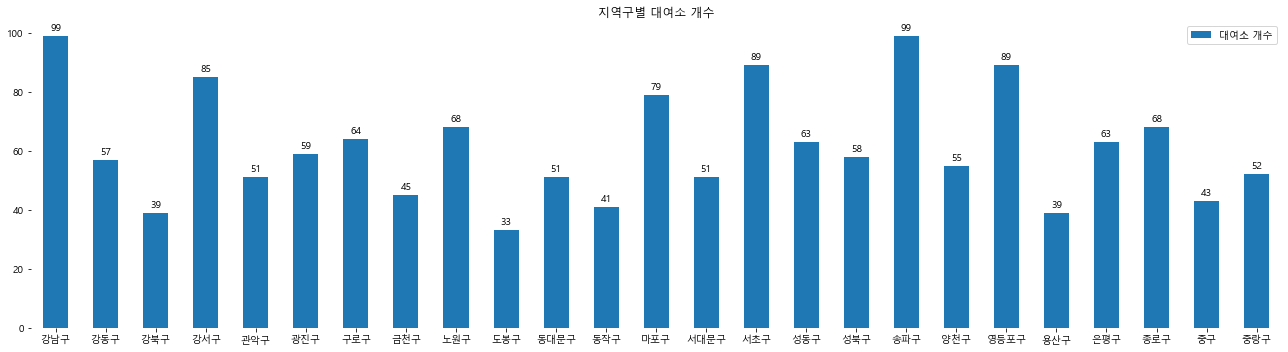

In [14]:
# 지역구별 대여소 개수를 그래프로 표시하였다.

ax = have_bikes.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구별 대여소 개수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

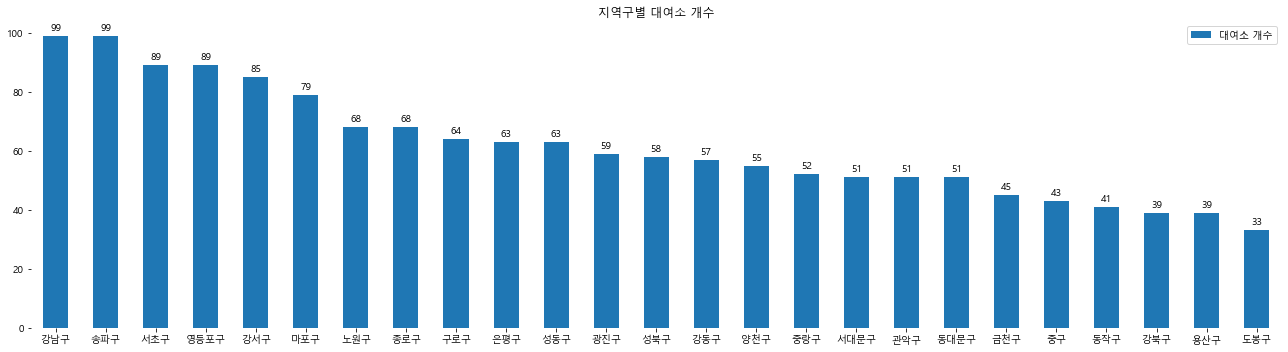

In [15]:
# 지역구별 대여소 개수를 내림차순 그래프로 표시하였다.

have_bikes_sort = have_bikes.sort_values(by=['대여소 개수'], axis=0, ascending=False)

ax = have_bikes_sort.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구별 대여소 개수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

In [16]:
# agg() 함수를 이용하여 지역구별로 대여소에 설치된 거치대수를 확인 할 수 있다.

have_bikes_total = rental.groupby(['대여소_구'])[['거치대수']].agg('sum')
have_bikes_total

,거치대수
대여소_구,
강남구,1218.0
강동구,763.0
강북구,451.0
강서구,1002.0
관악구,640.0
광진구,841.0
구로구,788.0
금천구,560.0
노원구,879.0


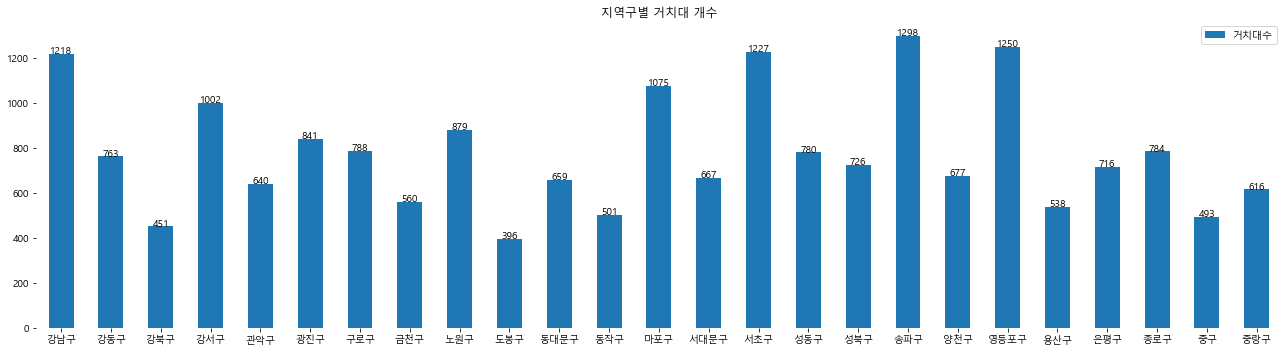

In [17]:
# 지역구별 총 거치대수를 확인 할 수 있다.

ax = have_bikes_total.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구별 거치대 개수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

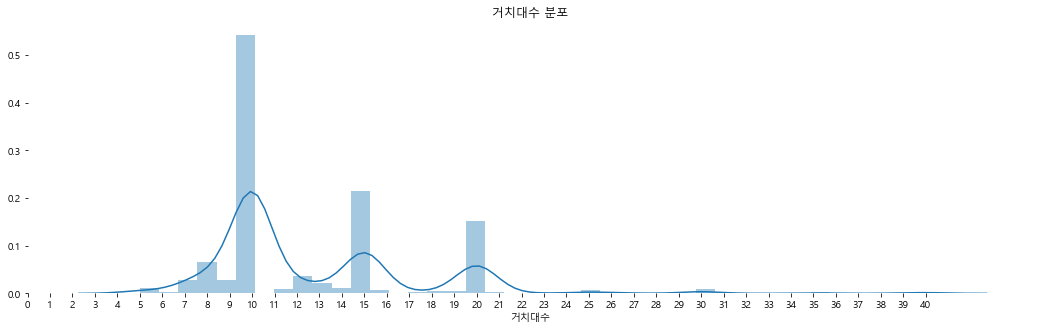

In [18]:
# 서울 시내 총 대여소별 거치대 설치의 분포정도를 확인 할 수 있다. 

plt.figure(figsize=(18, 5))
sns.distplot(rental['거치대수'])
plt.title("거치대수 분포")
plt.xticks(range(0, 41))
plt.box(False)
plt.show()

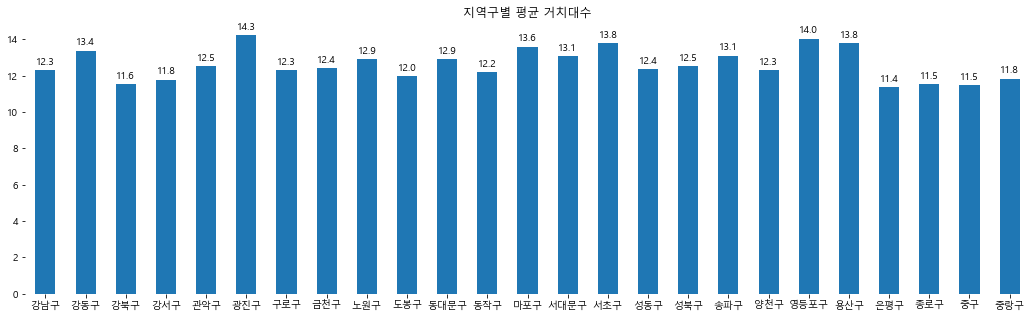

In [19]:
# 지역구별 평균 거치대수를 확인 할 수 있다.

bike_rental = rental.groupby('대여소_구')['거치대수'].sum()
bike_rental = bike_rental / bikes

ax = bike_rental.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구별 평균 거치대수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%.1f"%(height), (left+width/2, height+0.3), ha='center')
plt.box(False)
plt.xlabel("")
plt.show()

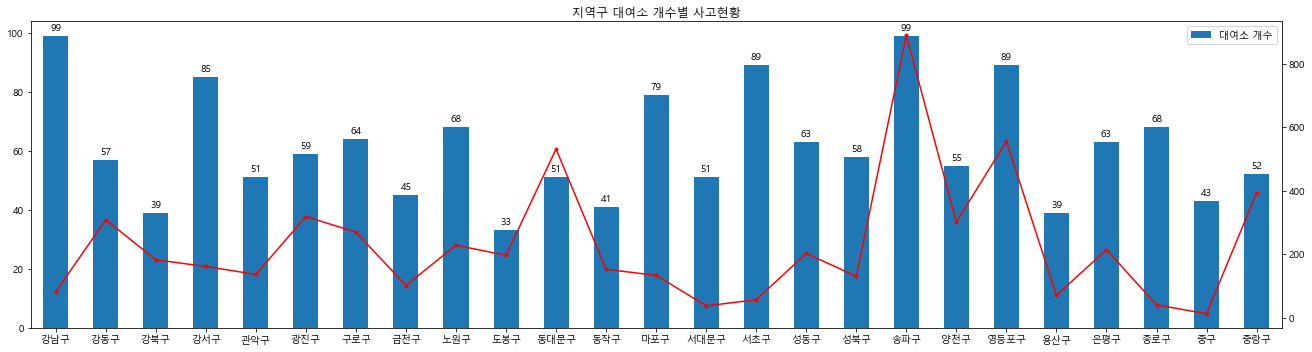

In [20]:
# 지역구 대여소수와 사고다발지점의 실제 사고 건수를 비교하였다.

ax = have_bikes.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구 대여소 개수별 사고현황")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')

plt.box(False)
plt.xlabel('')
plt.tight_layout()

plt.twinx() # bar 그래프와 plot 그래프 합치기
plt.plot(accident_seoul_gu_total ,'r.-')
# plt.legend(['사고다발지건수'])
# plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9))
plt.show()

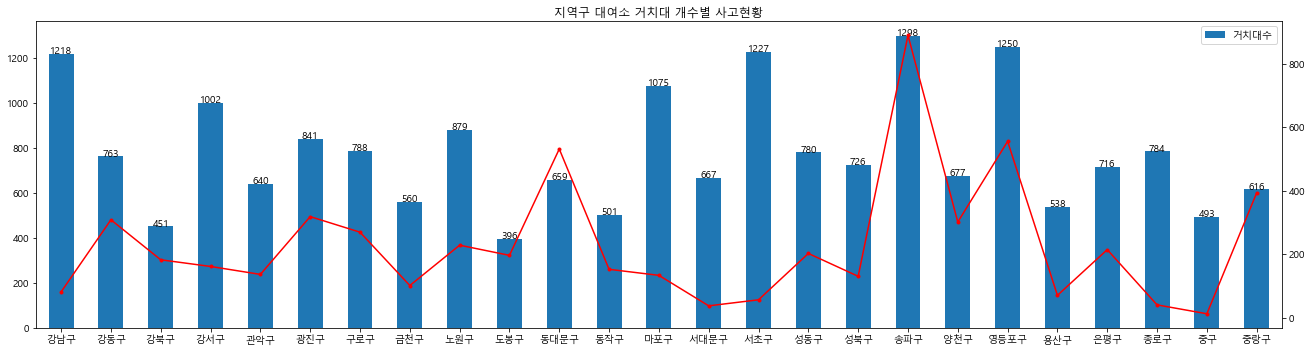

In [21]:
# 지역구 거치대수와 사고다발지점의 실제 사고 건수를 비교하였다.

ax = have_bikes_total.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구 대여소 거치대 개수별 사고현황")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')

plt.box(False)
plt.xlabel('')
plt.tight_layout()

plt.twinx() # bar 그래a프와 plot 그래프 합치기
plt.plot(accident_seoul_gu_total ,'r.-')
# plt.legend(['사고다발지건수'])
plt.show()

In [22]:
# 대여소간의 거리를 알기 위해서 각각의 위도와 경도의 거리 계산을 하는 함수를 만들었다.

from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    m = 1000 * km
    return m

In [23]:
# 지역구별로 경도와 위도를 돌면서 거리 계산을 하여 distance_gu 에 넣었다.

distance_gu = {}
for gu, df in rental.groupby('대여소_구'):
    distance_list = []
    for i, i_row in df.iterrows():
        min_dist = float('INF')
        for j, j_row in df.iterrows():
            if i == j:
                continue
            d = haversine(i_row['경도'], i_row['위도'], j_row['경도'], j_row['위도'])
            min_dist = d if d < min_dist else min_dist
            
        distance_list.append(min_dist)
    distance_gu[gu] = distance_list

In [24]:
distance_gu.items()

dict_items([('강남구', [648.4778278906048, 704.7472402575354, 685.7153235814396, 254.60732456420965, 236.10375240599265, 50.86071338037918, 271.96937124618546, 271.96937124618546, 130.93904608323766, 153.9942886881273, 248.88468046585837, 96.16173155997932, 608.5559577661594, 411.489447864134, 483.8222846269406, 109.29545561923368, 483.8222846269406, 467.03843593393515, 204.0082300382591, 565.5924010703615, 501.74159872507227, 134.24736926646725, 215.5141245903892, 215.5141245903892, 419.0448638407787, 419.0448638407787, 179.5607773110077, 144.98601380954014, 58.57402528928541, 183.28817468191363, 462.3828928901453, 345.0620820540274, 642.4425379986607, 147.82539093490792, 395.0856852081075, 76.07781749087899, 108.42742116490578, 252.87142908105264, 505.59821454127285, 366.28434659914166, 611.6629434859514, 577.1153083923407, 574.3623791625428, 121.19367746718324, 204.0082300382591, 373.4783587055429, 76.07781749087899, 366.28434659914166, 121.19367746718324, 248.88468046585837, 96.161731

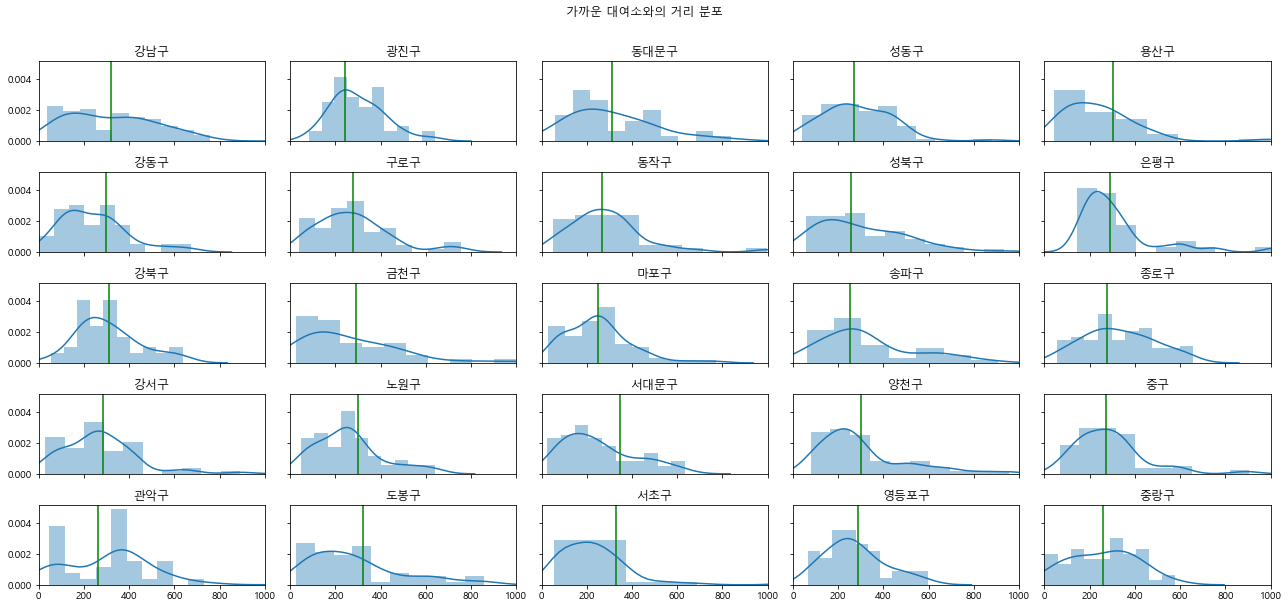

In [25]:
# 지역구별 가까운 대여소와의 거리 분포를 표로 표시하였다.

fig, axes = plt.subplots(5, 5, figsize=(18, 8), sharex=True, sharey=True)

i, j = 0, 0
for gu, distance_list in distance_gu.items():
    sns.distplot(distance_list, ax=axes[i][j], bins=10)
    axes[j][i].set_title(gu)
    axes[j][i].axvline(np.array(distance_list).mean(), color='green')
    j += 1
    if j >= 5:
        i += 1
        j = 0

fig.suptitle("가까운 대여소와의 거리 분포", y=1.05)
plt.xlim(0, 1000)
fig.tight_layout()
plt.show()

In [26]:
# 지역구별 평균 거리이다.

distance_means = {gu: np.mean(distance_list) for gu, distance_list in distance_gu.items() }
distance_means = pd.Series(distance_means)
distance_means.sort_values(inplace=True)

distance_means

광진구     244.595729
마포구     249.004180
송파구     252.241342
성북구     257.890745
중랑구     259.565812
관악구     263.209558
동작구     266.937932
성동구     270.340348
중구      272.904307
종로구     276.418481
구로구     279.134097
강서구     282.685137
영등포구    288.472792
은평구     289.008319
금천구     289.457561
강동구     299.037678
노원구     301.018164
양천구     302.398903
용산구     304.771790
동대문구    310.080729
강북구     312.422884
강남구     320.073554
도봉구     321.331211
서초구     329.861767
서대문구    348.434084
dtype: float64

In [27]:
distance_means.mean()

287.6518841319121

## 대여소수/거치대수와 사고다발지 실제 건수 간의 상관관계 비교

### 1. 대여소 개수와 사고다발지건수
### 2. 대여소 거치대수와 사고다발지건수
---------------------------------------------------------------------------------------------------------------------------------------

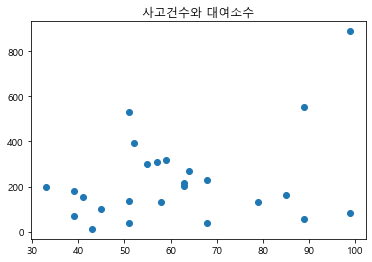

In [28]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 대여소수와 사고다발지점의 실제 사고건수를 비교하였다.

plt.title("사고건수와 대여소수")
plt.plot(have_bikes["대여소 개수"], accident_seoul_gu_total["발생건수"], 'o')
plt.show()

In [29]:
line_fitter = LinearRegression()
line_fitter.fit(have_bikes["대여소 개수"].values.reshape(-1,1), accident_seoul_gu_total["발생건수"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

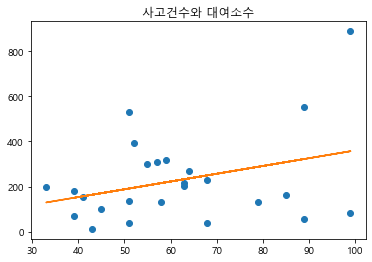

In [30]:
plt.plot(have_bikes["대여소 개수"], accident_seoul_gu_total["발생건수"], 'o')
plt.title("사고건수와 대여소수")
plt.plot(have_bikes["대여소 개수"],line_fitter.predict(have_bikes["대여소 개수"].values.reshape(-1,1)))
plt.show()

In [31]:
import scipy.stats as stats

corr1 = stats.pearsonr(have_bikes["대여소 개수"], accident_seoul_gu_total["발생건수"])
corr1

(0.33104908482721973, 0.10599500408771169)

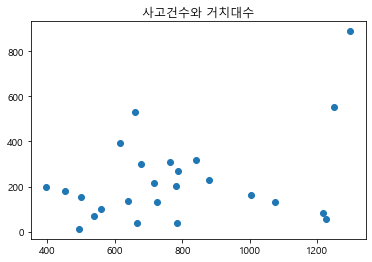

In [32]:
# 거치소수와 사고다발지점의 실제 사고건수를 비교하였다.

plt.plot(have_bikes_total["거치대수"], accident_seoul_gu_total["발생건수"], 'o')
plt.title("사고건수와 거치대수")
plt.show()

In [33]:
line_fitter = LinearRegression()
line_fitter.fit(have_bikes_total["거치대수"].values.reshape(-1,1), accident_seoul_gu_total["발생건수"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

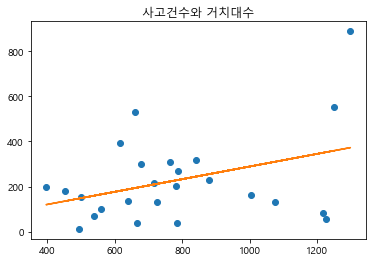

In [34]:
plt.plot(have_bikes_total["거치대수"], accident_seoul_gu_total["발생건수"], 'o')
plt.title("사고건수와 거치대수")
plt.plot(have_bikes_total["거치대수"],line_fitter.predict(have_bikes_total["거치대수"].values.reshape(-1,1)))
plt.show()

In [35]:
corr2 = stats.pearsonr(have_bikes_total["거치대수"], accident_seoul_gu_total["발생건수"])
corr2

(0.3720428151308132, 0.06704770946101223)